## Telluric correction with `muler` and `gollum`

Telluric correction can be complicated, with the right approach depending on one's own science application.  In this notebook we demonstrate one uncontroversial, albeit imperfect approach: dividing by an observed A0V standard, and multiplying back by an A0V template.

#### August 24, 2021: This method is under active development

In [1]:
%config InlineBackend.figure_format='retina'
from muler.hpf import HPFSpectrum

In [2]:
path = 'https://github.com/OttoStruve/muler_example_data/raw/main/HPF/01_A0V_standards/'
filename = 'Goldilocks_20210517T054403_v1.0_0060.spectra.fits'
spectrum = HPFSpectrum(file=path+filename, order=19)

In [3]:
spectrum = spectrum.normalize().sky_subtract(method='vector').deblaze().normalize()

### Retrieve and doctor the model with `gollum`

`gollum` is a sister project to muler.  While not a dependency, it has lots of parallel use cases and we hope you will install it too.  It makes it easy to retrieve and manipulate theoretical models.  Follow the instructions in gollum for downloading the raw high-resolution PHOENIX models.

In [4]:
from gollum.phoenix import PHOENIXSpectrum

In [5]:
wl_lo, wl_hi = spectrum.wavelength.min().value*0.998, spectrum.wavelength.max().value*1.002

In [6]:
native_resolution_template = PHOENIXSpectrum(teff=9600, logg=4.5, download=True,
                                             wl_lo=wl_lo, wl_hi=wl_hi).normalize()

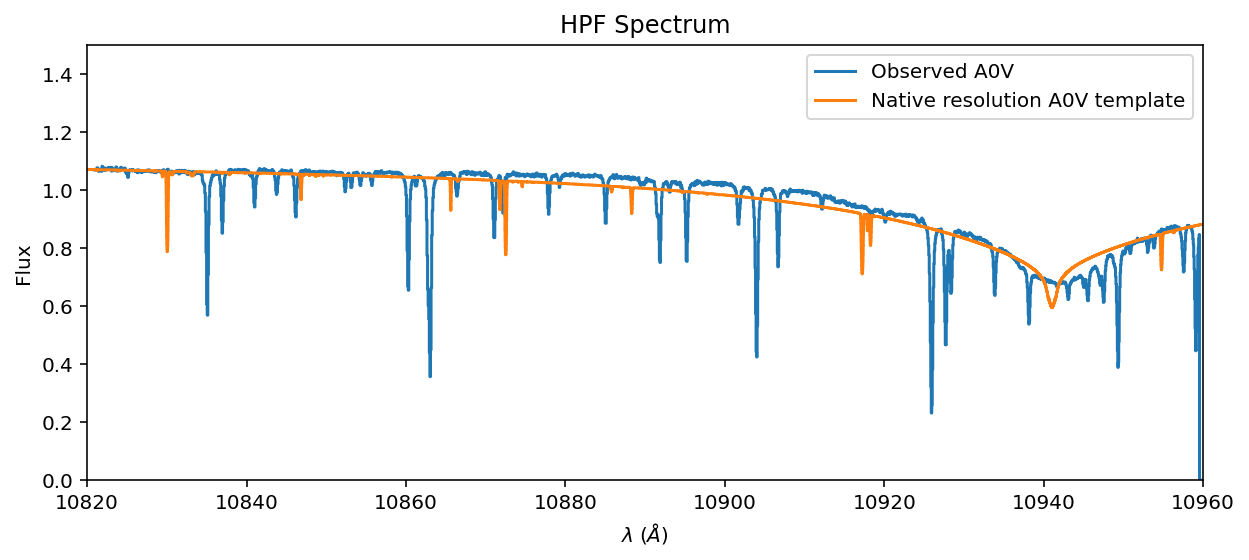

In [7]:
ax = spectrum.plot(ylo=0.0, yhi=1.5, label='Observed A0V')
native_resolution_template.plot(ax=ax, label='Native resolution A0V template')
ax.set_xlim(10_820, 10_960)
ax.legend();

The deep Hydrogen lines appear to have a different shape, since the A0V template is shown with near-infinite resolution.  Let's "doctor the template" with rotational broadening.

In [8]:
A0V_model = native_resolution_template.rotationally_broaden(130.0)
A0V_model = A0V_model.instrumental_broaden() # "just works" for HPF
A0V_model = A0V_model.rv_shift(25.0)
A0V_model = A0V_model.resample(spectrum)

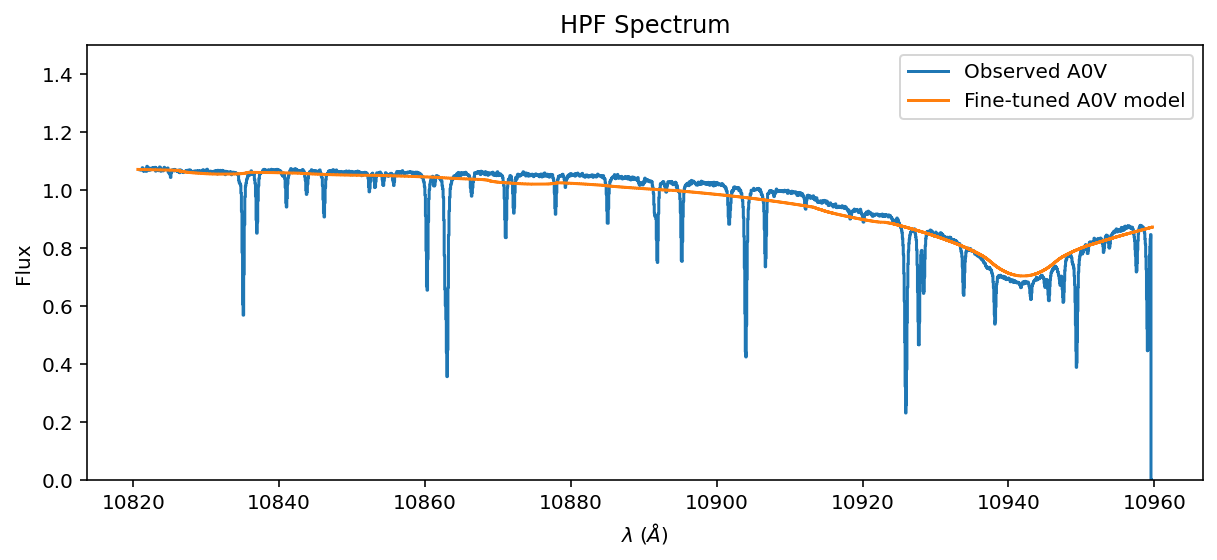

In [9]:
ax = spectrum.plot(ylo=0.0, yhi=1.5, label='Observed A0V')
A0V_model.plot(ax=ax, label='Fine-tuned A0V model')
ax.legend();

Awesome!  That's a better fit!  Let's compute the ratio.

In [10]:
telluric_response = spectrum / A0V_model

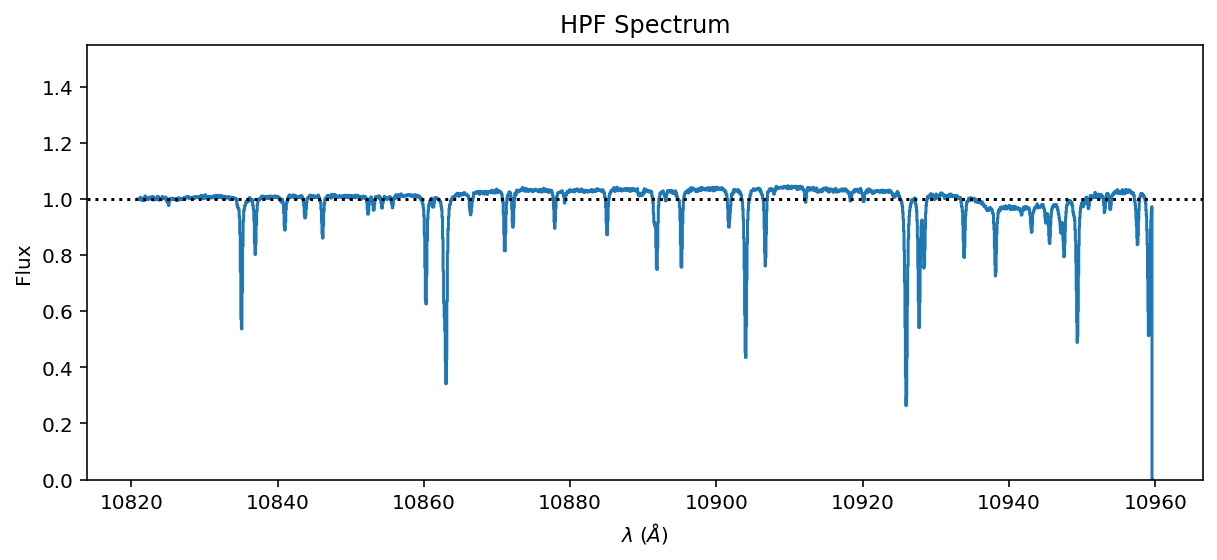

In [11]:
ax = telluric_response.plot(ylo=0);
ax.axhline(1.0, linestyle='dotted', color='k');

We see that the telluric response exhibits sharp discrete lines from the atmosphere.  The spectrum also exhibits a smooth continuum variation likely attributable to the imperfections in the A0V templates.  The imperfect A0V templates are a known limitation of this telluric correction strategy.  